# Multivariate Time Series Forecasting with LSTMs in Keras
#### Reference: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

##### Train On Single Lag Timestep - Avg meters for 5 given area groups

In [1]:
from math import sqrt
from numpy import concatenate, savetxt, unique, array
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM


Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
# load dataset
dataset = read_csv('CharlestownAllGroupBy.csv', header=0, sep='[,]', parse_dates=True, squeeze=True, dayfirst=True, engine='python') 
#print(dataset.head())
dataset.drop(dataset.columns[[0,2]], axis = 1, inplace = True)
dataset = dataset[['kWh', 'Temp', 'Area_m2', 'Month', 'Weekday', 'Holiday']]
values = dataset.values
#print(dataset.head())
# ensure all data is float
values = values.astype('float32')
#savetxt('CharlestownValues.csv', values, delimiter=',')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
#reframed.dtypes
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
#print(reframed.head())
#shuffle rows
reframed=reframed.sample(frac=1).reset_index(drop=True)
#print(reframed.head())

In [4]:
# split into train and test sets
values = reframed.values
n_train_periods = int(len(values)*0.8)
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


Train on 1316 samples, validate on 329 samples
Epoch 1/100
 - 1s - loss: 0.1679 - val_loss: 0.1500
Epoch 2/100
 - 0s - loss: 0.1285 - val_loss: 0.1172
Epoch 3/100
 - 0s - loss: 0.1018 - val_loss: 0.0886
Epoch 4/100
 - 0s - loss: 0.0726 - val_loss: 0.0600
Epoch 5/100
 - 0s - loss: 0.0489 - val_loss: 0.0432
Epoch 6/100
 - 0s - loss: 0.0371 - val_loss: 0.0391
Epoch 7/100
 - 0s - loss: 0.0350 - val_loss: 0.0371
Epoch 8/100
 - 0s - loss: 0.0331 - val_loss: 0.0351
Epoch 9/100
 - 0s - loss: 0.0317 - val_loss: 0.0345
Epoch 10/100
 - 0s - loss: 0.0315 - val_loss: 0.0334
Epoch 11/100
 - 0s - loss: 0.0307 - val_loss: 0.0327
Epoch 12/100
 - 0s - loss: 0.0305 - val_loss: 0.0325
Epoch 13/100
 - 0s - loss: 0.0304 - val_loss: 0.0320
Epoch 14/100
 - 0s - loss: 0.0301 - val_loss: 0.0323
Epoch 15/100
 - 0s - loss: 0.0301 - val_loss: 0.0319
Epoch 16/100
 - 0s - loss: 0.0301 - val_loss: 0.0319
Epoch 17/100
 - 0s - loss: 0.0301 - val_loss: 0.0318
Epoch 18/100
 - 0s - loss: 0.0300 - val_loss: 0.0314
Epoch 19

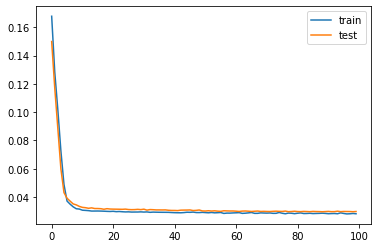

In [5]:
# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=84, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#pyplot.show()


In [6]:
# make a prediction using 20% of the 5 meter groups 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.502


In [7]:
# make a prediction using all indivdual meter data
# load dataset
dataset = read_csv('CharlestownAll.csv', header=0, sep='[,]', parse_dates=True, squeeze=True, dayfirst=True, engine='python') 
#dataset = dataset.loc[dataset['MeterNo'] == 6]
dataset.drop(dataset.columns[[0,2,5,8]], axis = 1, inplace = True)
dataset = dataset[['kWh', 'Temp', 'Area_m2', 'Month', 'Weekday', 'Holiday']]
values = dataset.values
# ensure all data is float
values = values.astype('float32')
#savetxt('CharlestownValues.csv', values, delimiter=',')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
#print(reframed.head())
#shuffle rows
reframed=reframed.sample(frac=1).reset_index(drop=True)
#print(reframed.head())
values = reframed.values
# split into input and outputs
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(test_X.shape, test_y.shape)
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.758


In [8]:
# make a prediction using data from a single meter
# load dataset
dataset = read_csv('CharlestownAll.csv', header=0, sep='[,]', parse_dates=True, squeeze=True, dayfirst=True, engine='python') 
#dataset = dataset.loc[dataset['MeterNo'] <3]
meter_ids = unique(dataset['MeterNo'])
#print(meter_ids)
results = dict()
results_df = []
for m in meter_ids:
    dataset = read_csv('CharlestownAll.csv', header=0, sep='[,]', parse_dates=True, squeeze=True, dayfirst=True, engine='python') 
    dataset = dataset.loc[dataset['MeterNo'] == m]
    dataset.drop(dataset.columns[[0,2,5,8]], axis = 1, inplace = True)
    dataset = dataset[['kWh', 'Temp', 'Area_m2', 'Month', 'Weekday', 'Holiday']]
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    #savetxt('CharlestownValues.csv', values, delimiter=',')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
    #print(reframed.head())
    #shuffle rows
    reframed=reframed.sample(frac=1).reset_index(drop=True)
    #print(reframed.head())
    values = reframed.values
    # split into input and outputs
    test_X, test_y = values[:, :-1], values[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(test_X.shape, test_y.shape)
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('MeterNo %s - Test RMSE: %.3f' % (m, rmse))
    results[m] = rmse #dict
    results_df.append([m, rmse]) #array

MeterNo 1 - Test RMSE: 3.032
MeterNo 2 - Test RMSE: 6.253
MeterNo 3 - Test RMSE: 6.476
MeterNo 4 - Test RMSE: 3.620
MeterNo 5 - Test RMSE: 2.756
MeterNo 6 - Test RMSE: 9.948
MeterNo 7 - Test RMSE: 4.671
MeterNo 8 - Test RMSE: 4.169
MeterNo 9 - Test RMSE: 2.246
MeterNo 10 - Test RMSE: 5.757
MeterNo 11 - Test RMSE: 5.158
MeterNo 12 - Test RMSE: 5.963
MeterNo 13 - Test RMSE: 4.998
MeterNo 14 - Test RMSE: 3.966
MeterNo 15 - Test RMSE: 9.150
MeterNo 16 - Test RMSE: 6.943
MeterNo 17 - Test RMSE: 4.341
MeterNo 18 - Test RMSE: 5.859
MeterNo 19 - Test RMSE: 4.570
MeterNo 20 - Test RMSE: 4.542
MeterNo 21 - Test RMSE: 4.566
MeterNo 22 - Test RMSE: 10.712
MeterNo 23 - Test RMSE: 9.738
MeterNo 24 - Test RMSE: 6.435
MeterNo 25 - Test RMSE: 7.646
MeterNo 26 - Test RMSE: 4.836
MeterNo 27 - Test RMSE: 4.661
MeterNo 28 - Test RMSE: 5.250
MeterNo 29 - Test RMSE: 5.658
MeterNo 30 - Test RMSE: 4.338
MeterNo 31 - Test RMSE: 2.959
MeterNo 32 - Test RMSE: 3.079
MeterNo 33 - Test RMSE: 3.570
MeterNo 34 - Test 

MeterNo 269 - Test RMSE: 6.245
MeterNo 270 - Test RMSE: 5.901
MeterNo 271 - Test RMSE: 7.238
MeterNo 272 - Test RMSE: 7.656
MeterNo 273 - Test RMSE: 4.507
MeterNo 274 - Test RMSE: 5.185
MeterNo 275 - Test RMSE: 5.584
MeterNo 276 - Test RMSE: 6.893
MeterNo 277 - Test RMSE: 5.742
MeterNo 278 - Test RMSE: 5.281
MeterNo 279 - Test RMSE: 5.388
MeterNo 280 - Test RMSE: 11.455
MeterNo 281 - Test RMSE: 9.709
MeterNo 282 - Test RMSE: 9.439
MeterNo 283 - Test RMSE: 7.276
MeterNo 284 - Test RMSE: 7.103
MeterNo 285 - Test RMSE: 7.668


In [9]:
results_df=DataFrame(results_df)
results_df.columns = ['MeterID', 'RMSE']
print(results_df)
#type(results_df)

     MeterID      RMSE
0          1  3.032319
1          2  6.252751
2          3  6.475554
3          4  3.619977
4          5  2.756373
..       ...       ...
280      281  9.709321
281      282  9.438989
282      283  7.275848
283      284  7.102911
284      285  7.667659

[285 rows x 2 columns]


In [10]:
results_df.to_csv('CharlestownGroupByRSMEs.csv')

In [11]:
results_df.drop(results_df.columns[[0]], axis = 1, inplace = True)

In [14]:
results_df.min()


RMSE    0.0332
dtype: float64

In [15]:
results_df.max()

RMSE    12.975556
dtype: float64

In [16]:
results_df.mean()

RMSE    5.261634
dtype: float64